In [1]:
import pandas as pd
import numpy as np
import os
from os import walk
import glob
import pprint
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
from scipy.stats import boxcox
%matplotlib inline

In [130]:
os.getcwd()

'/environment/notebooks/timeseries'

In [2]:
# Читает имена файлов в директории
path = '/environment/notebooks/timeseries/1._Лекция_tsml/Series/'
f = []
for (dirpath, dirnames, filenames) in walk(path):
    f.extend(filenames)
    break

In [27]:
# создает пачку датафреймов из файлов, присваивает каждому имя переменной

dfs = {f'{file[0:-4]}_df'.replace('-','_'): pd.read_csv(path+file, parse_dates=True, index_col=0) for file in f}
for key, df in dfs.items():
   globals()[key] = df

print(dfs.keys())

dict_keys(['daily_total_female_births_in_cal_df', 'international_airline_passengers_df', 'mean_monthly_air_temperature_deg_df', 'monthly_boston_armed_robberies_j_df', 'monthly_sales_of_company_x_jan_6_df', 'weekly_closings_of_the_dowjones__df'])


In [134]:
os.chdir('/environment/notebooks/timeseries')

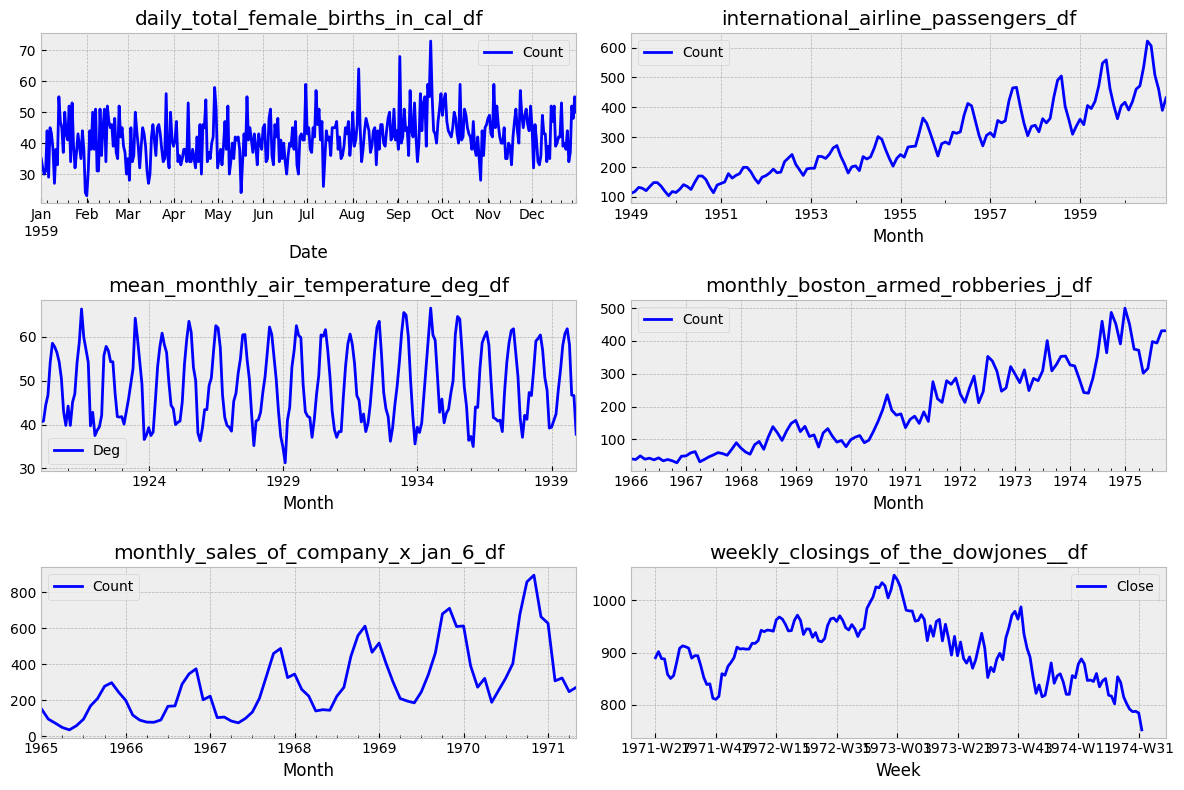

In [28]:
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 8))
    layout = (3, 2)
    for i, key in enumerate(dfs.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        dfs[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

## Тест на стационарность

### Тест Дики Фуллера

In [29]:
from statsmodels.tsa.stattools import adfuller, kpss

def Dickey_Fuller(df_name, df):
    timeseries = df
    print(f'Results of Dickey-Fuller Test for {df_name}:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    
    return dfoutput

In [30]:
# Н0 - Временной ряд - нестационраный
for df_name, df in dfs.items():    
    print(Dickey_Fuller(df_name, df), '\n')

Results of Dickey-Fuller Test for daily_total_female_births_in_cal_df:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64 

Results of Dickey-Fuller Test for international_airline_passengers_df:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64 

Results of Dickey-Fuller Test for mean_monthly_air_temperature_deg_df:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.0000

In [37]:
def item_popper(dct, item_list):
    new_dct = dct.copy()
    for item in item_list:
        if item in dct.keys():
            del new_dct[item]
    return new_dct

#### Результаты:
    Стационарные ряды, Н0 отвергается:
    - daily_total_female_births_in_cal_df. p-value: 0.000052
    - mean_monthly_air_temperature_deg_df. p-value: 0.016989, присутствует явная сезонность ряда
    Остальные - нестационарные

### Автокорреляция

In [40]:
def tsplot(y, df_name, lags=None, figsize=(10, 8), style='bmh'):
    # if not isinstance(y, pd.Series):
    #     y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title(f'{df_name}: Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

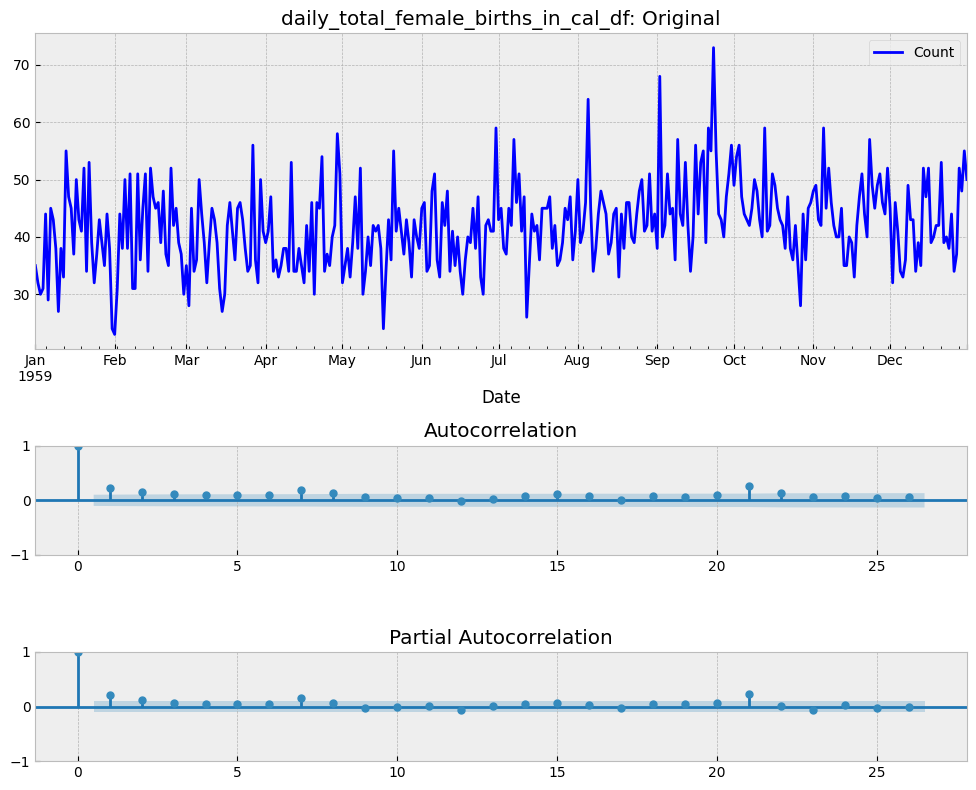

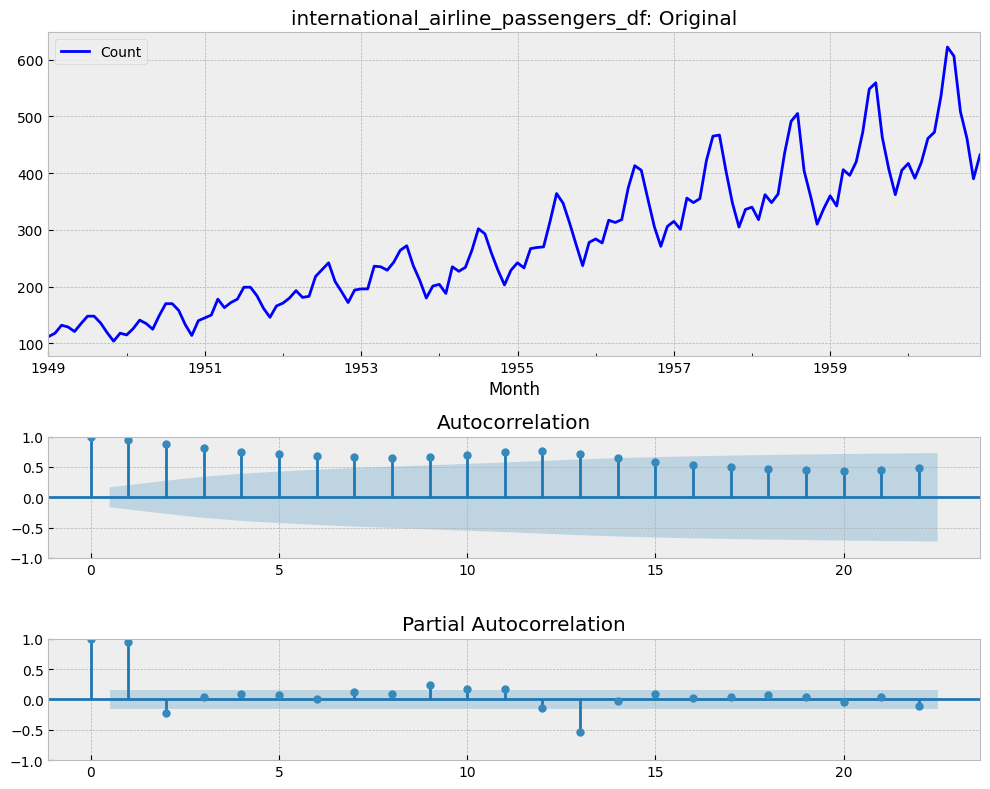

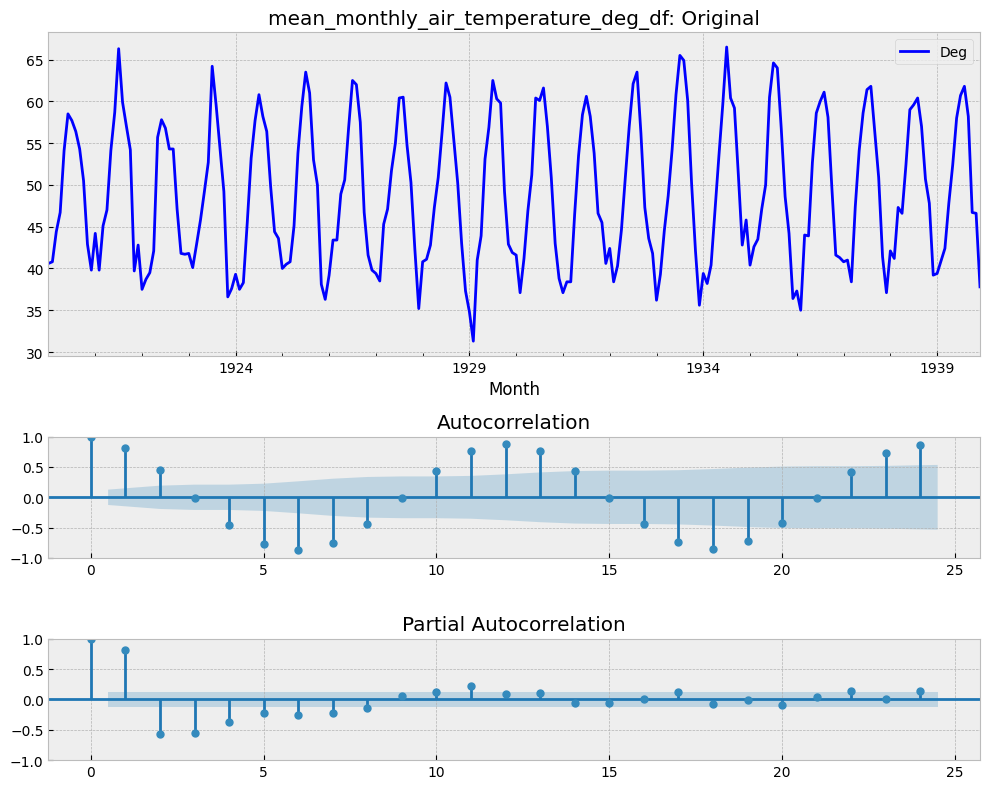

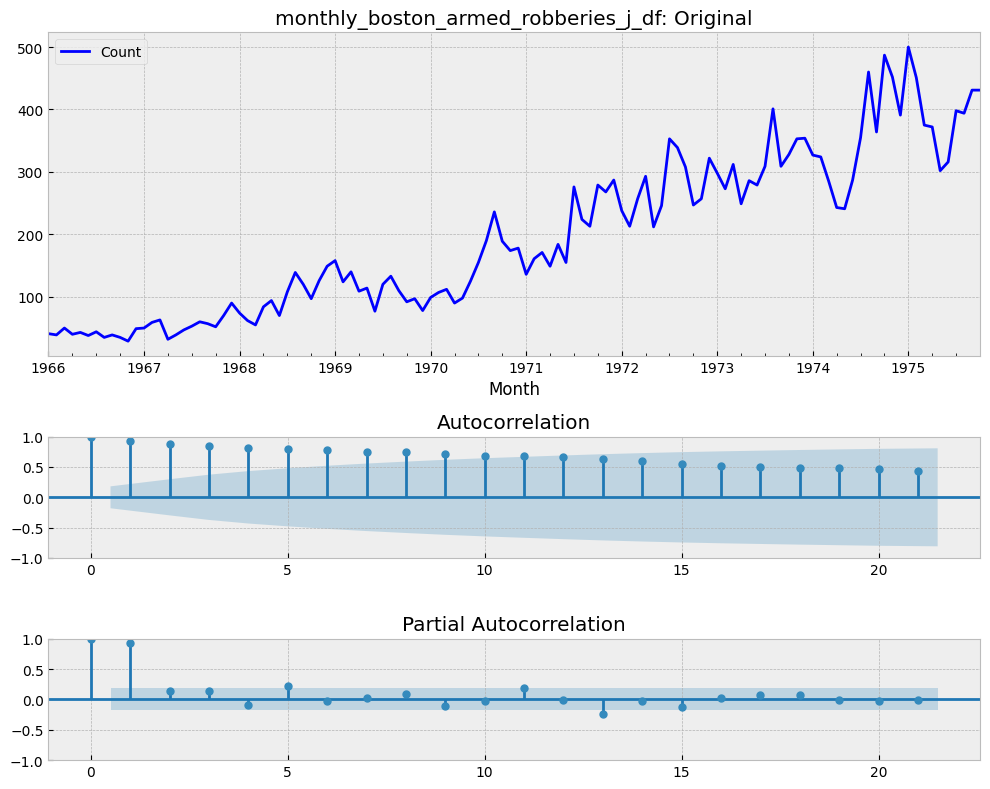

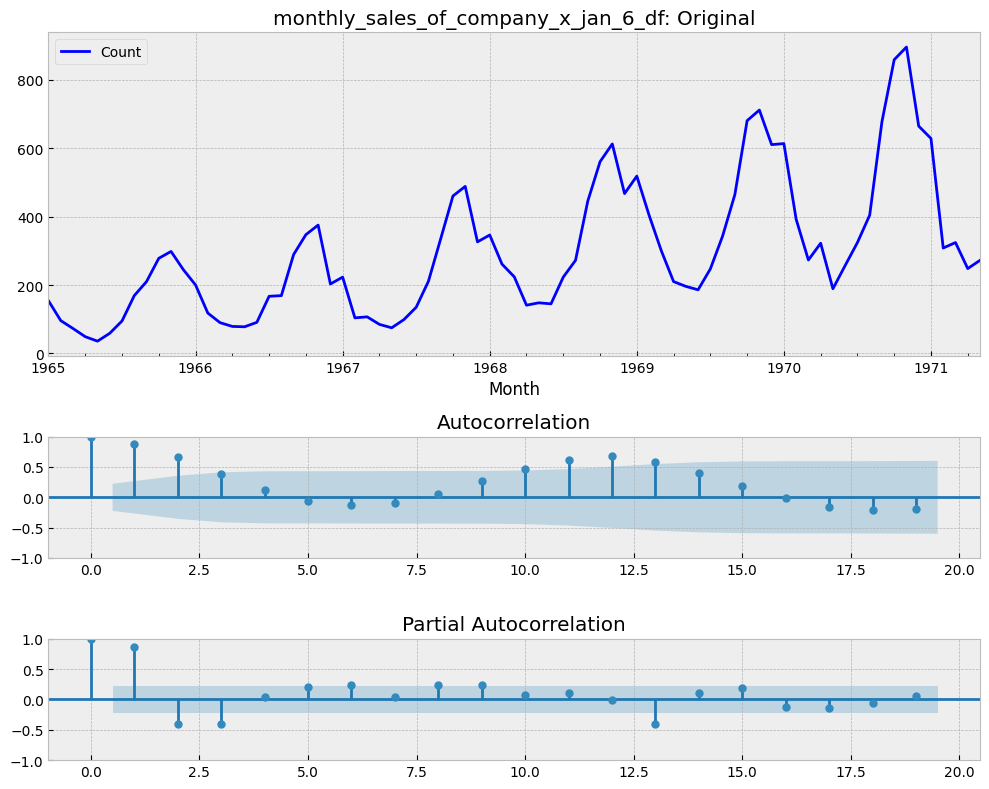

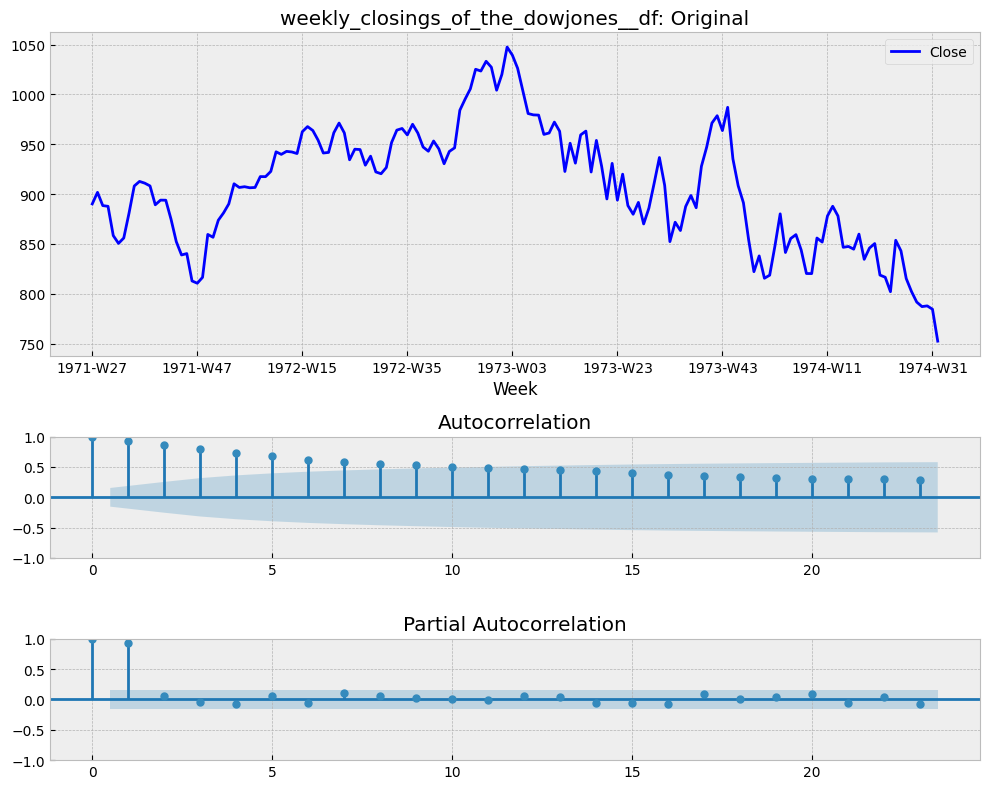

In [41]:
for df_name, df in dfs.items():
    tsplot(df, df_name)

In [42]:
dfs2 = item_popper(dfs, ['daily_total_female_births_in_cal_df'])

График автокорреляции быстро убывает только для ряда daily_total_female_births_in_cal_df, что говорит о его стационарности. Остальные ряды стационарными не являются.

## Приведение к стационарности

Box Cox

Results of Dickey-Fuller Test for international_airline_passengers_df:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
Results of Dickey-Fuller Test for mean_monthly_air_temperature_deg_df:
Test Statistic                  -3.760996
p-value                          0.003333
#Lags Used                      15.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64
Results of Dickey-Fuller Test for monthly_boston_armed_robberies_j_df:
Test Statistic                  -2.013161
p-value                          0.280833
#Lags Used                      10.000000
Number of Observations Used    107.000000
C

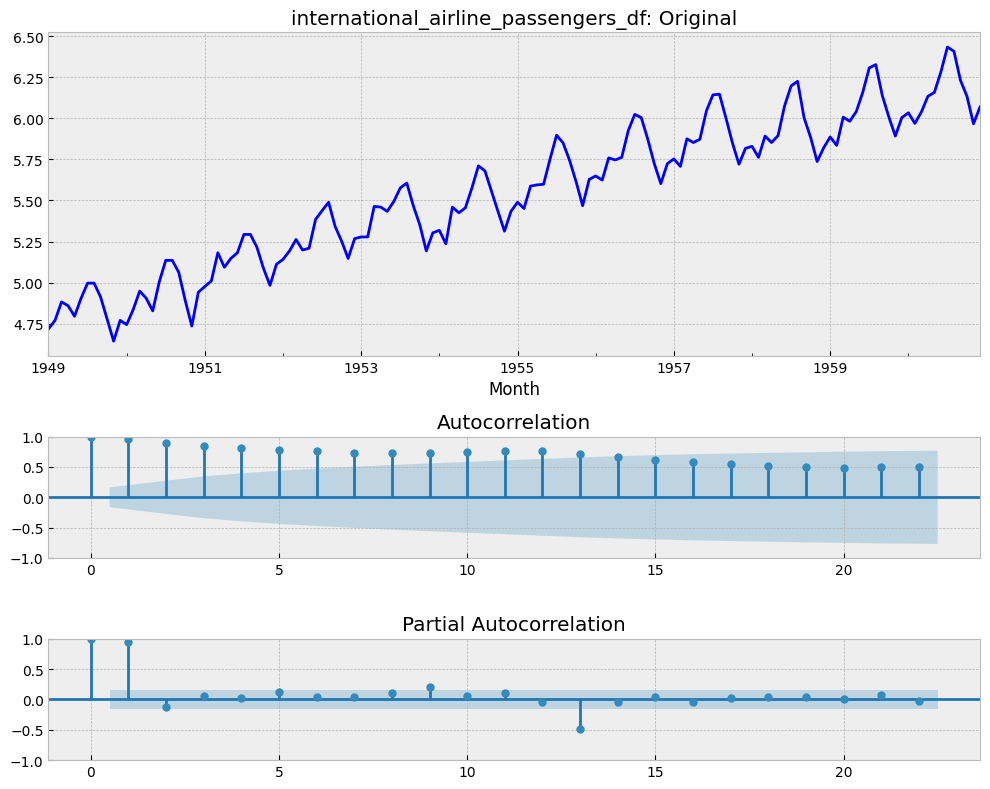

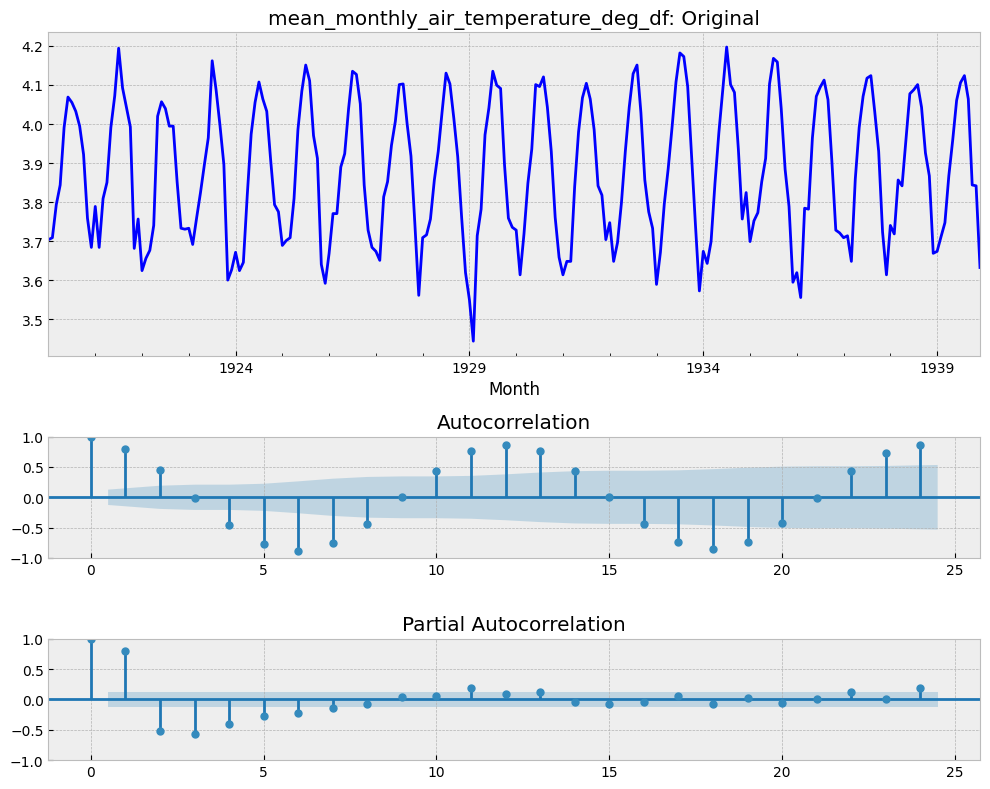

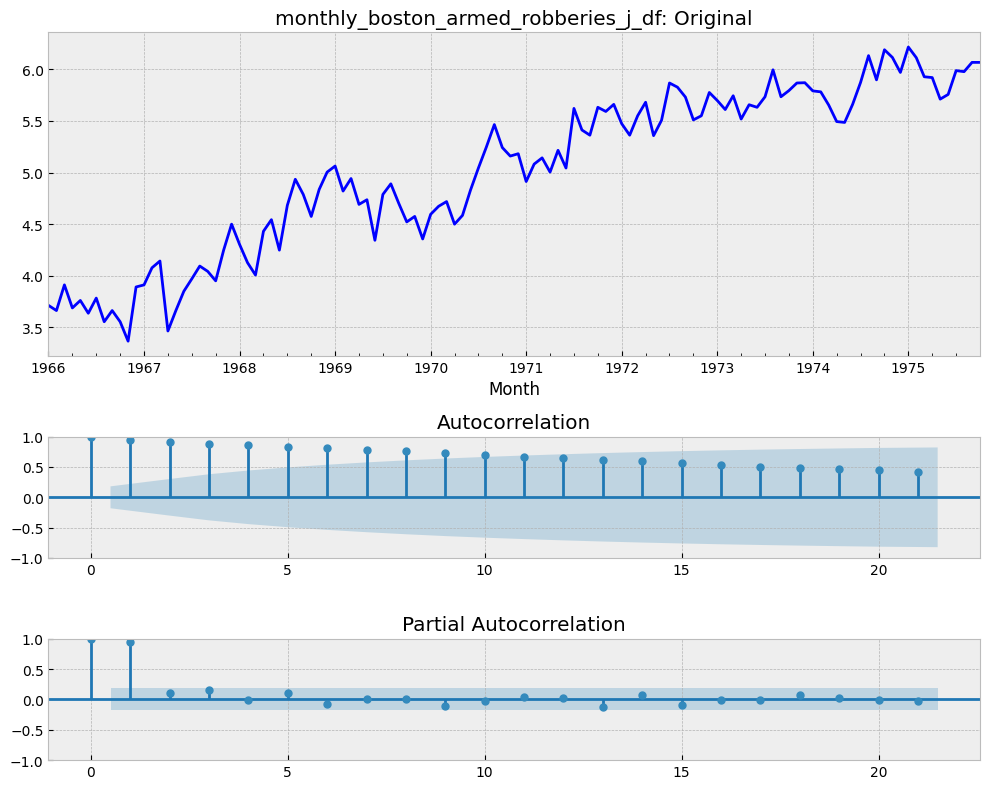

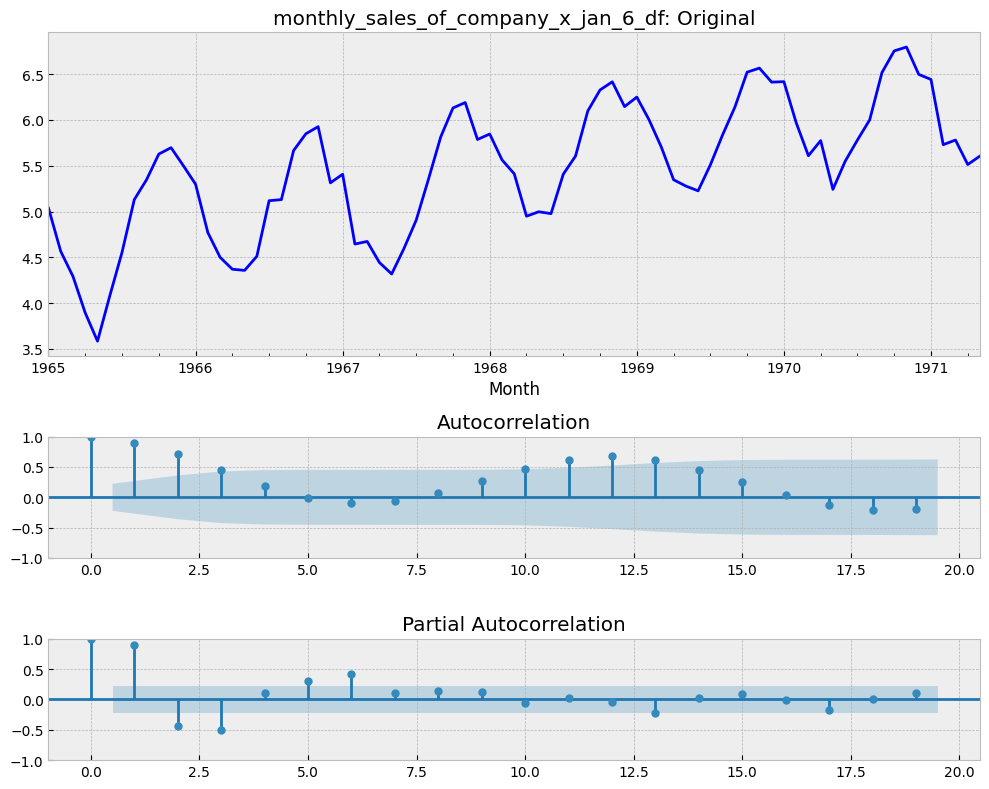

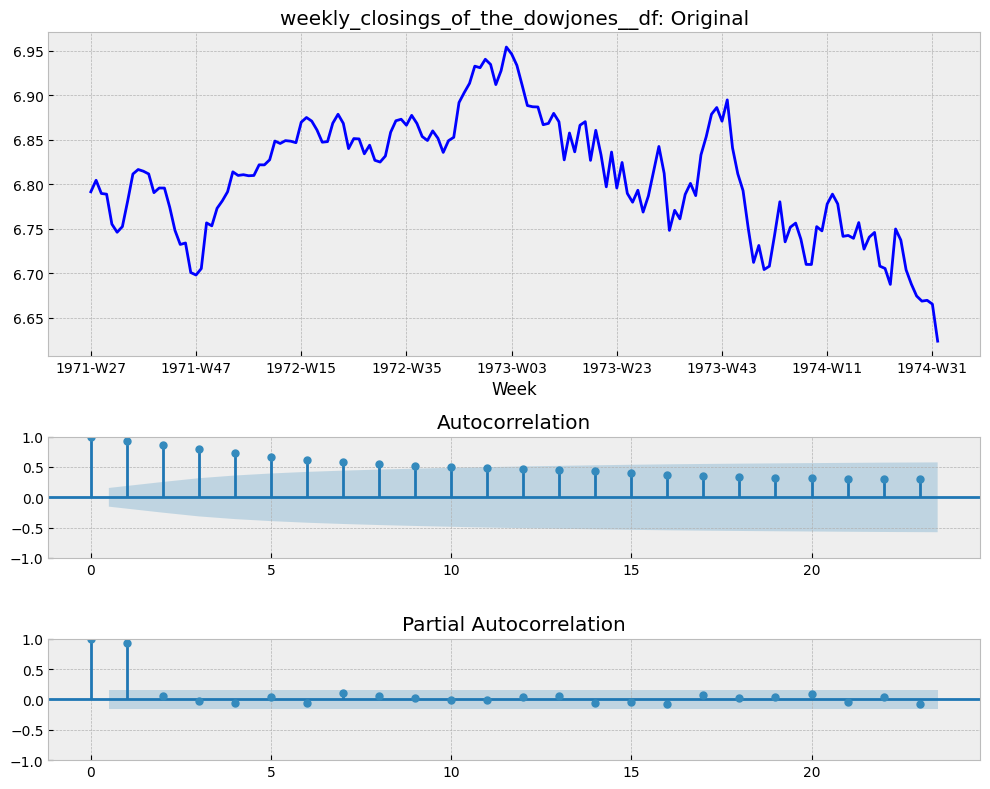

In [44]:
for ts_name, ts in dfs2.items():
    ts = boxcox(ts.iloc[:,0], 0)
    print(Dickey_Fuller(ts_name, ts))
    tsplot(ts, ts_name)

In [35]:
dfs.keys()

dict_keys(['daily_total_female_births_in_cal_df', 'international_airline_passengers_df', 'mean_monthly_air_temperature_deg_df', 'monthly_boston_armed_robberies_j_df', 'monthly_sales_of_company_x_jan_6_df', 'weekly_closings_of_the_dowjones__df'])

### Сезонность

Явная сезонность у след. рядов:

    - international_airline_passengers_df

    - mean_monthly_air_temperature_deg_df
    
    - monthly_sales_of_company_x_jan_6_df

In [45]:
def differ(df, periods):
    df = df.iloc[:,0].diff(periods = periods)
    return df

Results of Dickey-Fuller Test for international_airline_passengers_df:
Test Statistic                  -3.383021
p-value                          0.011551
#Lags Used                       1.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
Results of Dickey-Fuller Test for mean_monthly_air_temperature_deg_df:
Test Statistic                -6.072501e+00
p-value                        1.141945e-07
#Lags Used                     1.200000e+01
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64
Results of Dickey-Fuller Test for monthly_boston_armed_robberies_j_df:
Test Statistic                 -2.288406
p-value                         0.175734
#Lags Used                     13.000000
Number of Observations Used    9

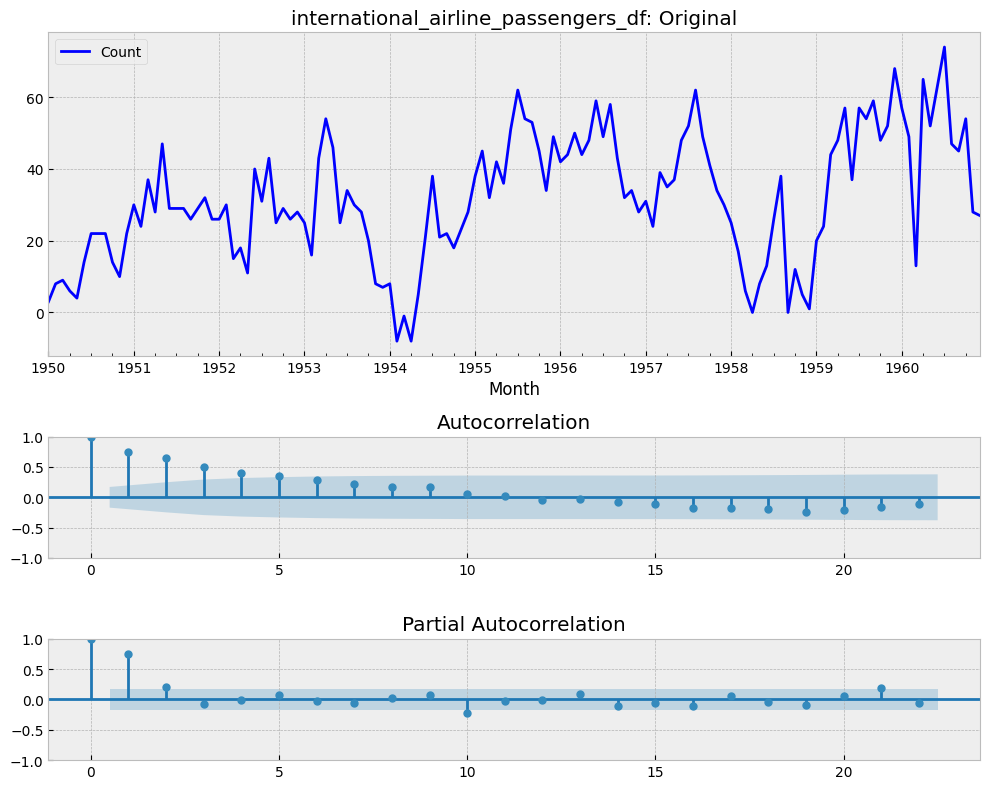

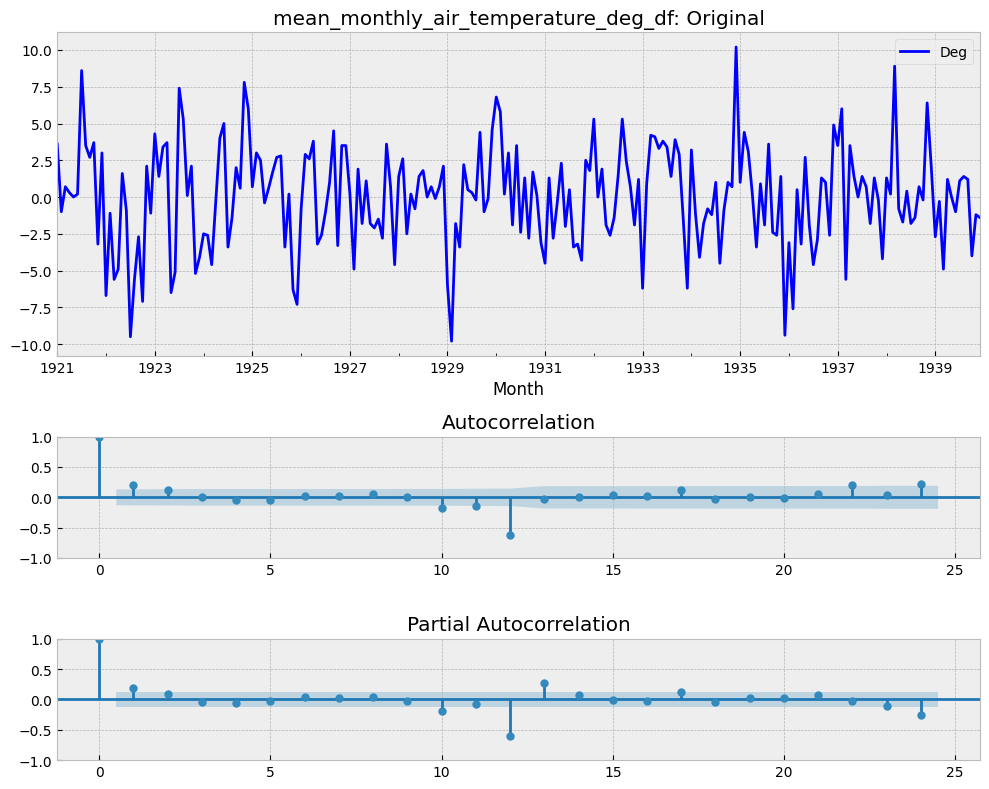

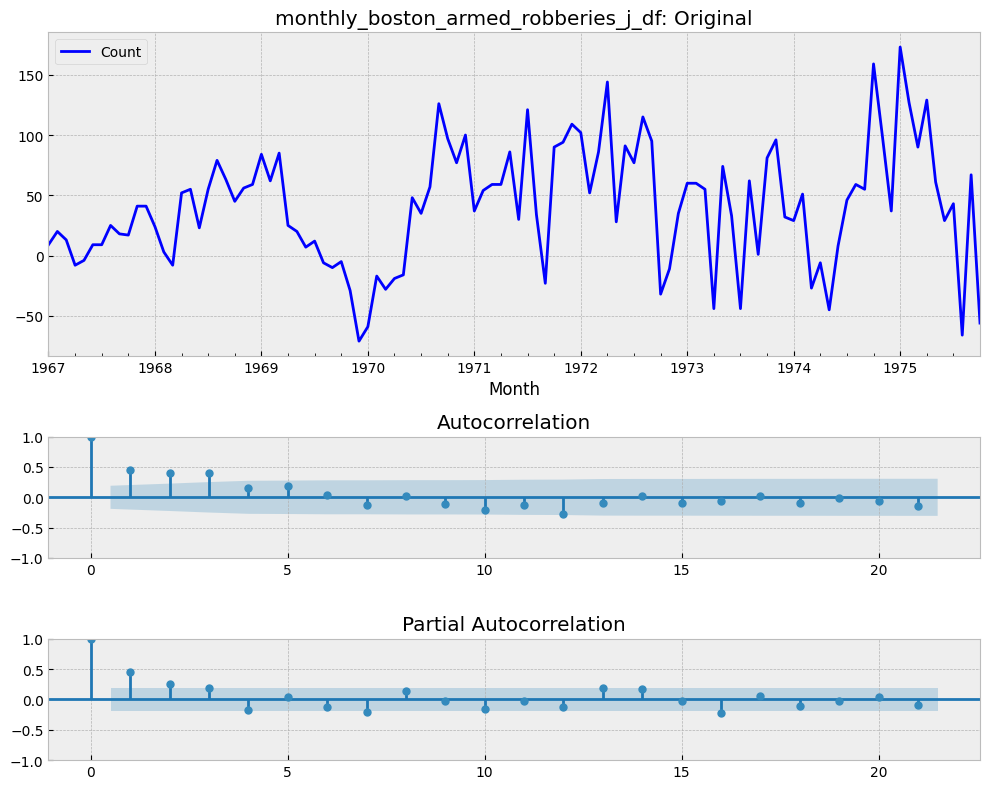

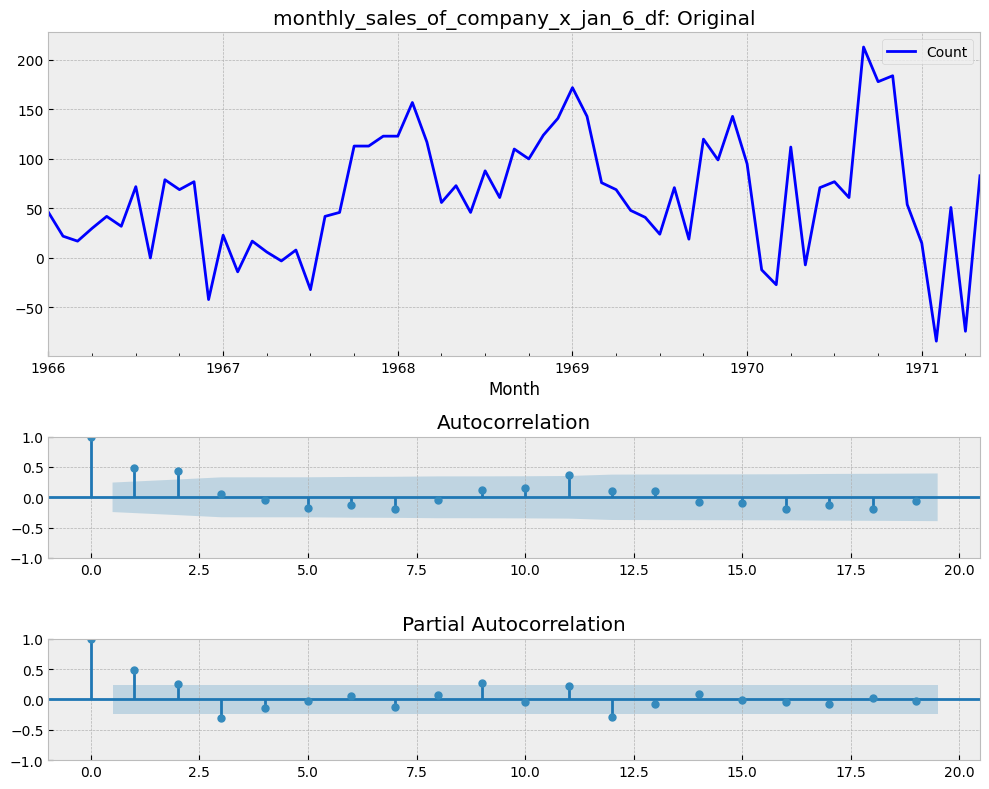

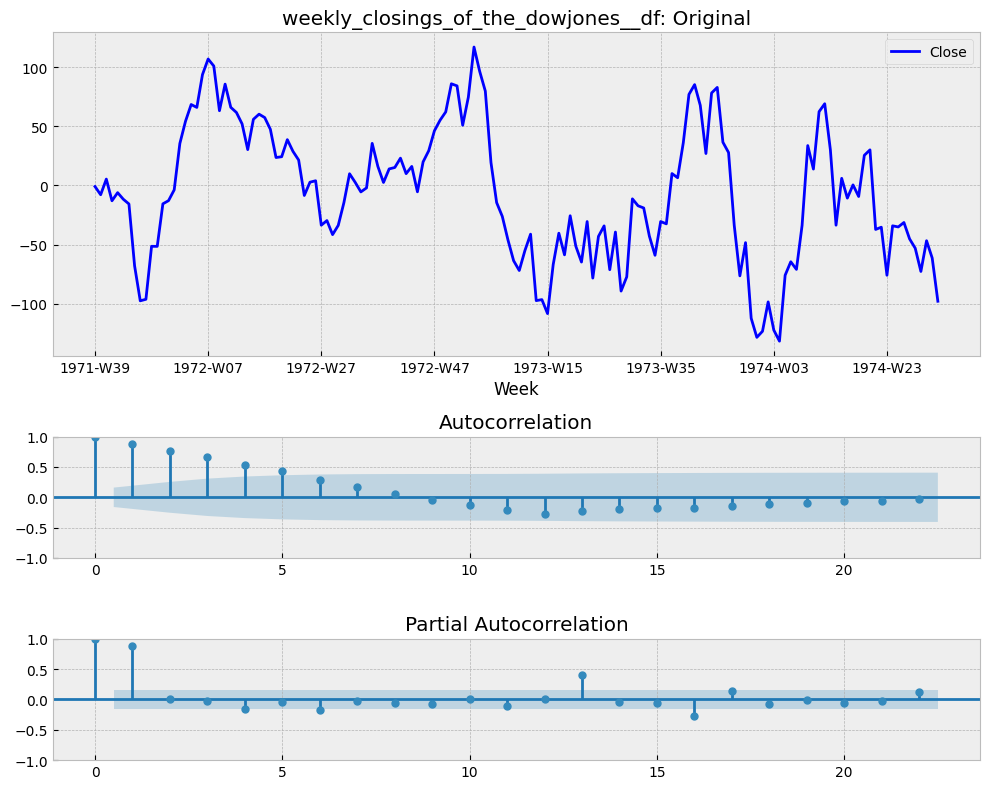

In [47]:
diffed12 = {}
for k, v in dfs2.items():
    diffed12.update({k:pd.DataFrame(differ(v, 12).dropna(axis = 'index'))})
for k, v in diffed12.items():
    print(Dickey_Fuller(k,v))
    tsplot(v, k)

Results of Dickey-Fuller Test for international_airline_passengers_df:
Test Statistic                  -2.278166
p-value                          0.179107
#Lags Used                       1.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64
Results of Dickey-Fuller Test for mean_monthly_air_temperature_deg_df:
Test Statistic                  -4.369902
p-value                          0.000335
#Lags Used                      12.000000
Number of Observations Used    191.000000
Critical Value (1%)             -3.465059
Critical Value (5%)             -2.876794
Critical Value (10%)            -2.574901
dtype: float64
Results of Dickey-Fuller Test for monthly_boston_armed_robberies_j_df:
Test Statistic                 -1.733381
p-value                         0.414001
#Lags Used                     12.000000
Number of Observations Used    69.000000
Criti

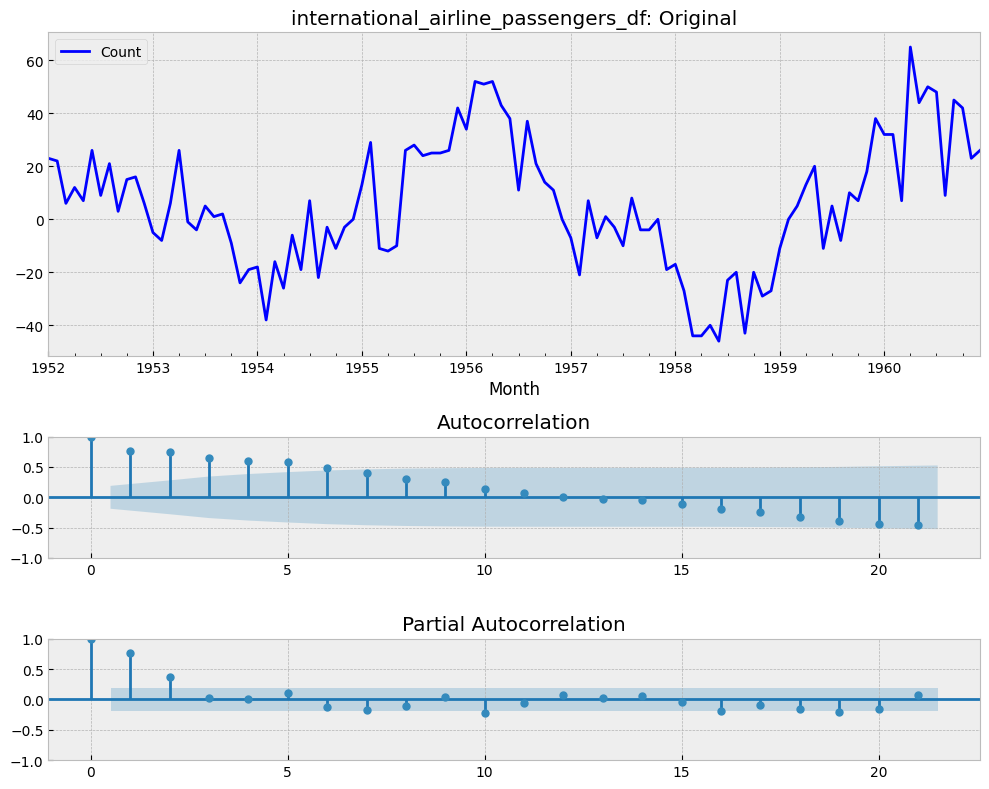

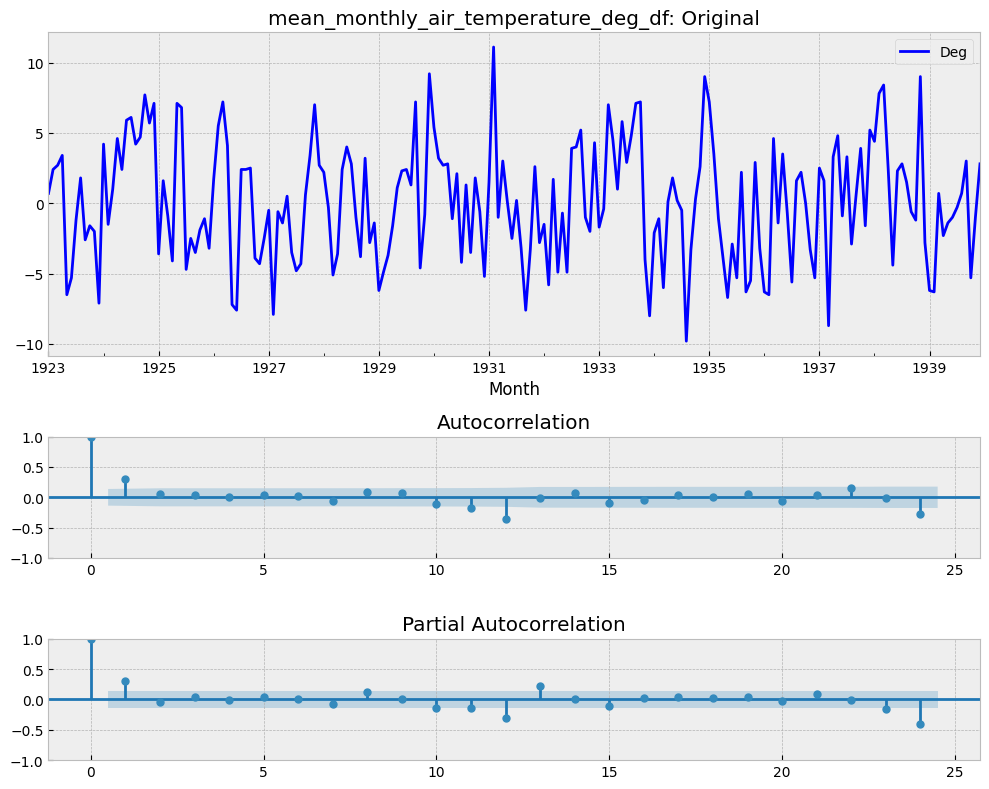

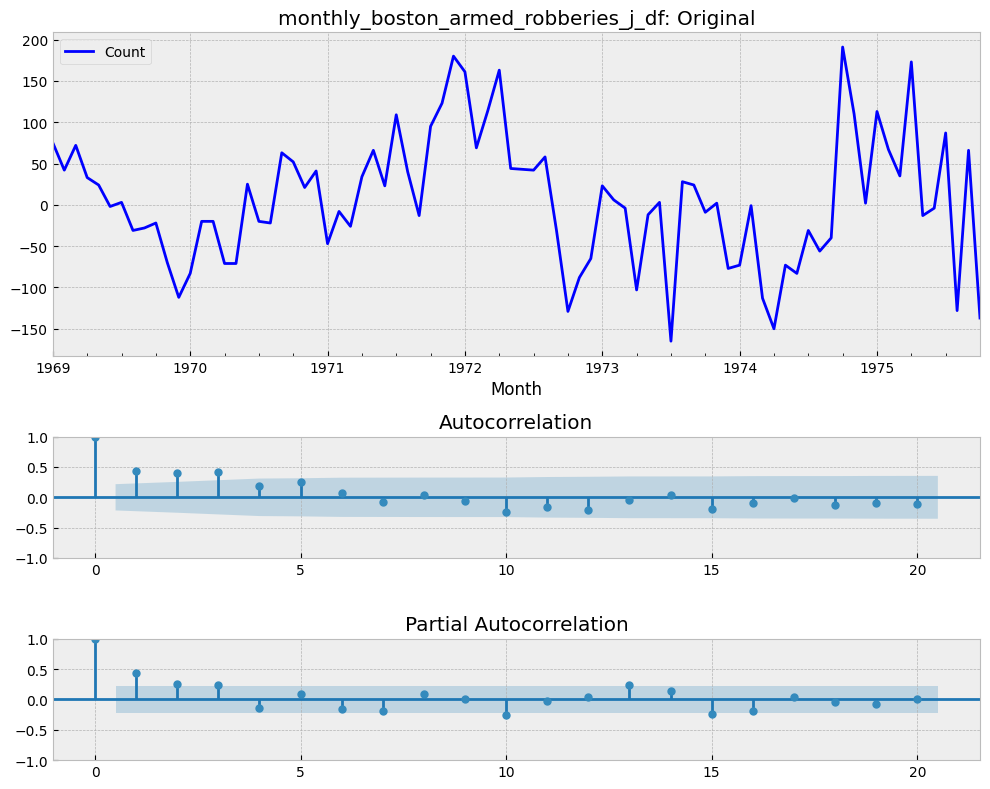

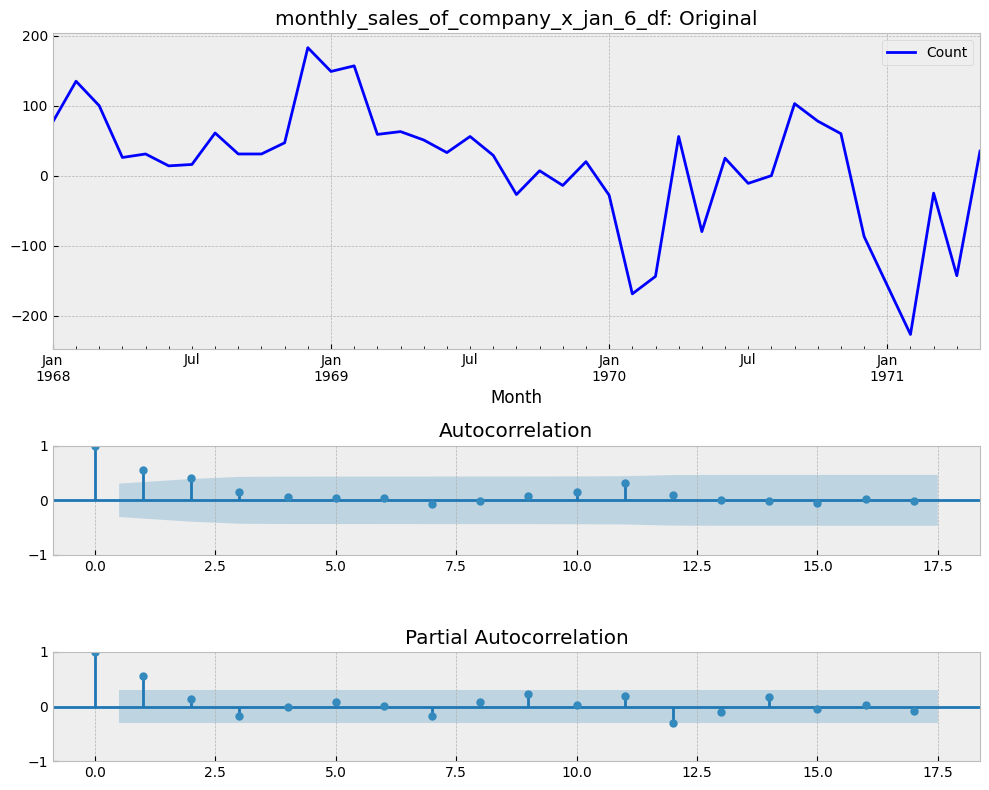

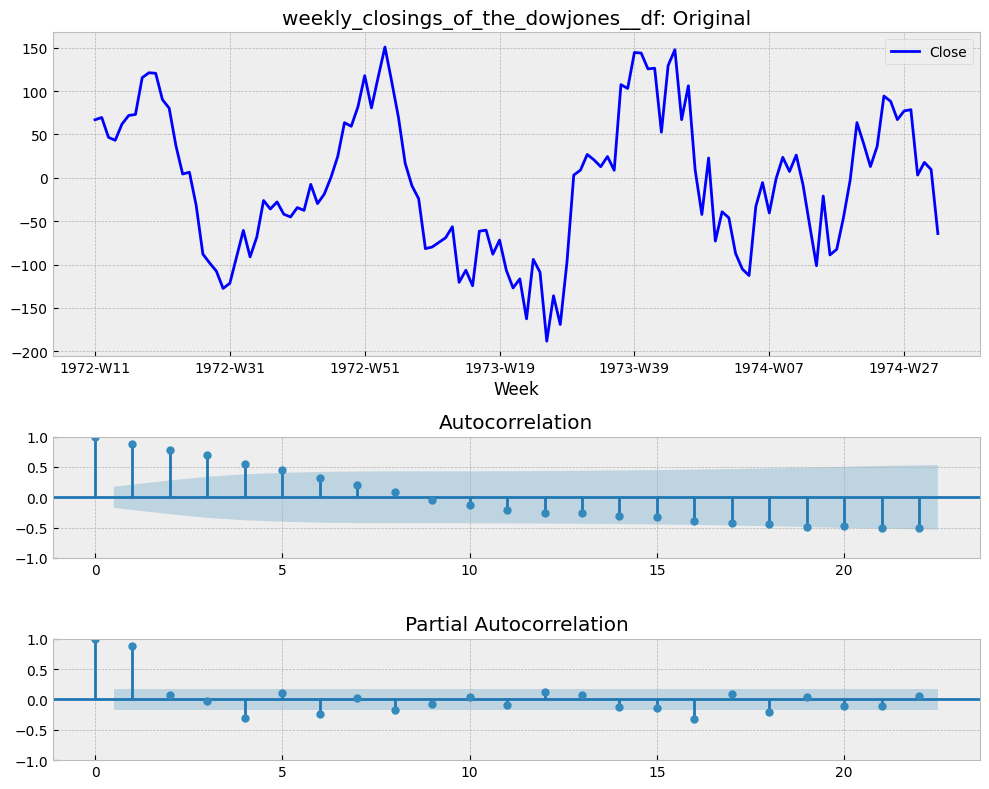

In [48]:
diffed24 = {}
for k, v in diffed12.items():
    diffed24.update({k:pd.DataFrame(differ(v, 24).dropna(axis = 'index'))})
for k, v in diffed24.items():
    print(Dickey_Fuller(k,v))
    tsplot(v, k)

In [80]:
poplist = ['mean_monthly_air_temperature_deg_df',
           'monthly_sales_of_company_x_jan_6_df',]
        #    'weekly_closings_of_the_dowjones__df']

dfs3 = item_popper(diffed24, poplist)

Results of Dickey-Fuller Test for international_airline_passengers_df:
Test Statistic                -1.647685e+01
p-value                        2.256144e-29
#Lags Used                     0.000000e+00
Number of Observations Used    1.060000e+02
Critical Value (1%)           -3.493602e+00
Critical Value (5%)           -2.889217e+00
Critical Value (10%)          -2.581533e+00
dtype: float64
Results of Dickey-Fuller Test for monthly_boston_armed_robberies_j_df:
Test Statistic                 -4.219348
p-value                         0.000611
#Lags Used                     11.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64
Results of Dickey-Fuller Test for weekly_closings_of_the_dowjones__df:
Test Statistic                  -3.994398
p-value                          0.001440
#Lags Used                       4.000000
Number of Observations Used    120.0

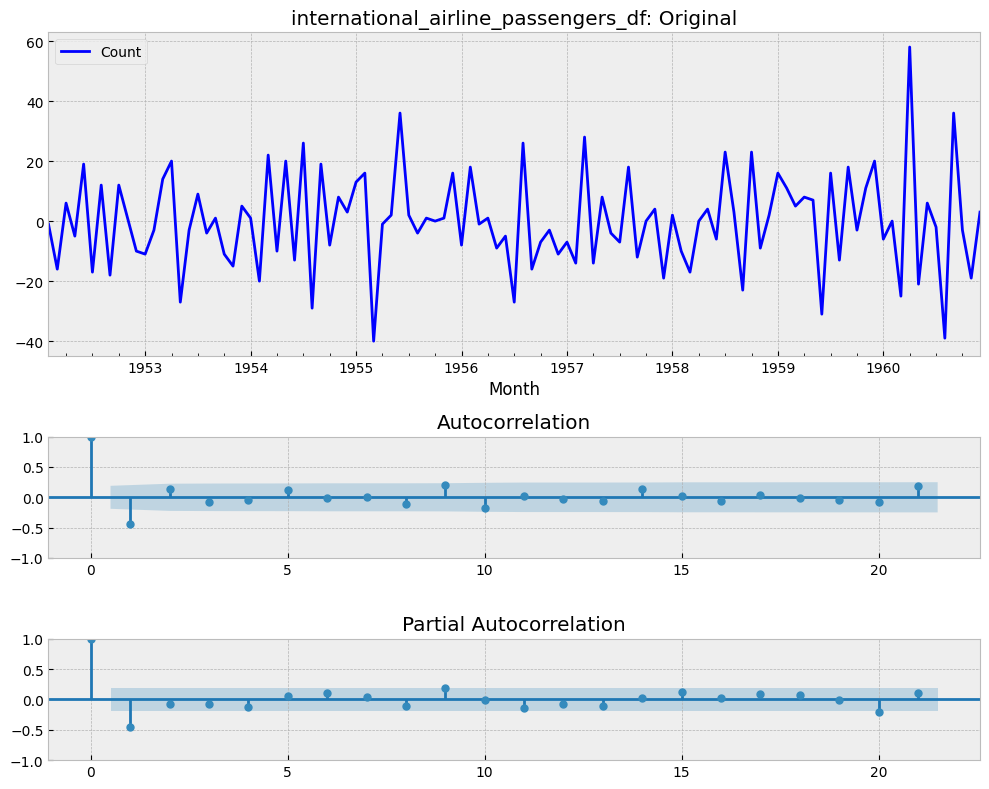

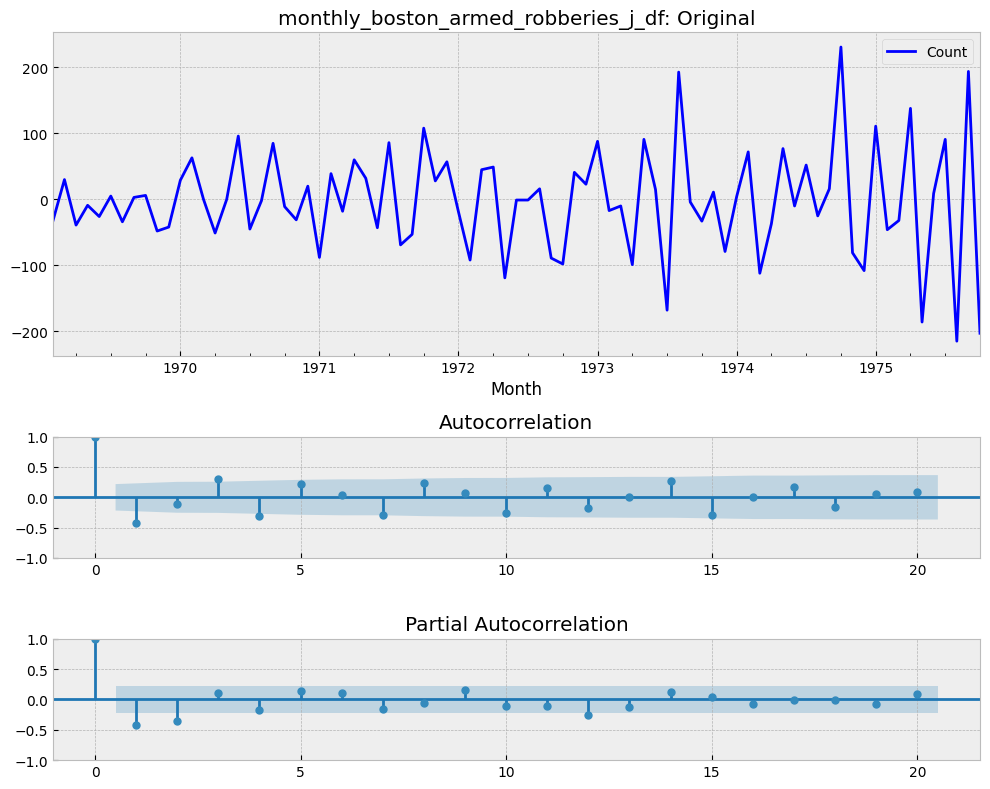

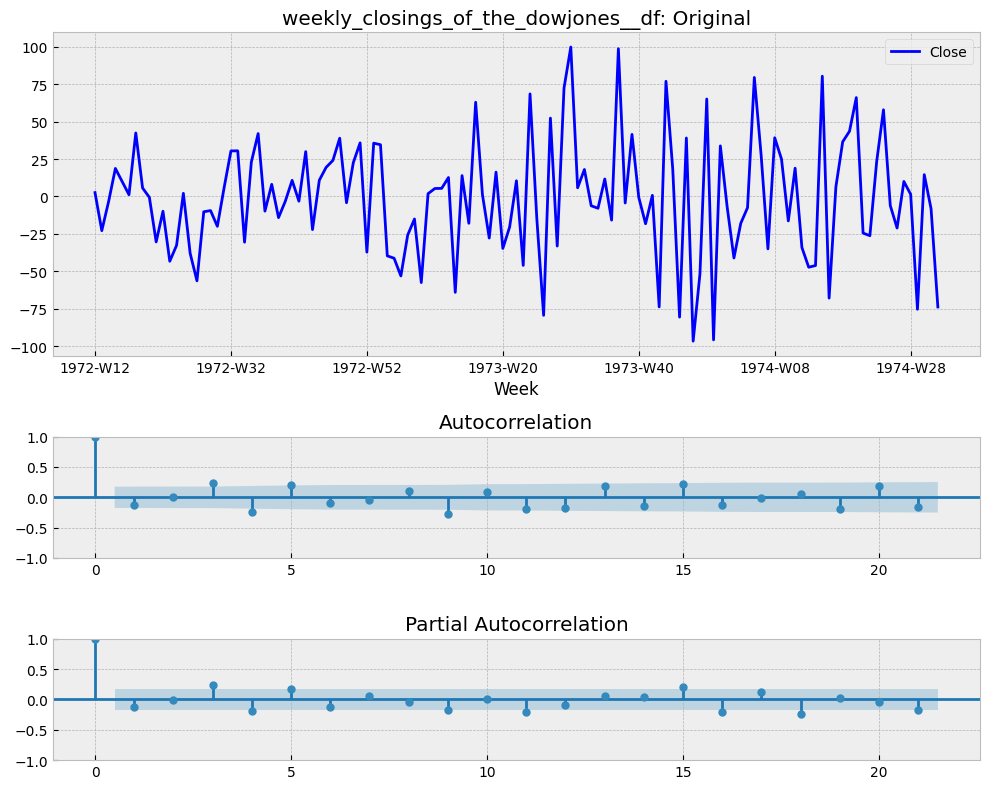

In [97]:
diffed1 = {}
for k, v in dfs3.items():
    diffed1.update({k:pd.DataFrame(differ(v, 1).dropna(axis = 'index'))})
for k, v in diffed1.items():
    print(Dickey_Fuller(k,v))
    tsplot(v, k)